In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [105]:
transform = transforms.Compose([transforms.ToTensor(),
                                # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                transforms.Resize(224), 
                                transforms.CenterCrop(224),
                                transforms.Grayscale(3)])

In [127]:
dataset = datasets.ImageFolder("archive (1)\Brain Tumor Data Set\Brain Tumor Data Set", transform=transform)
class_name = dataset.classes
batch_size = 10

In [128]:
train_size = int(0.7*(len(dataset)))
test_size = int(0.3*(len(dataset)))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [129]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

Label: [0 1 1 0 0 0 1 1 1 0]
Class: Brain Tumor Healthy Healthy Brain Tumor Brain Tumor Brain Tumor Healthy Healthy Healthy Brain Tumor


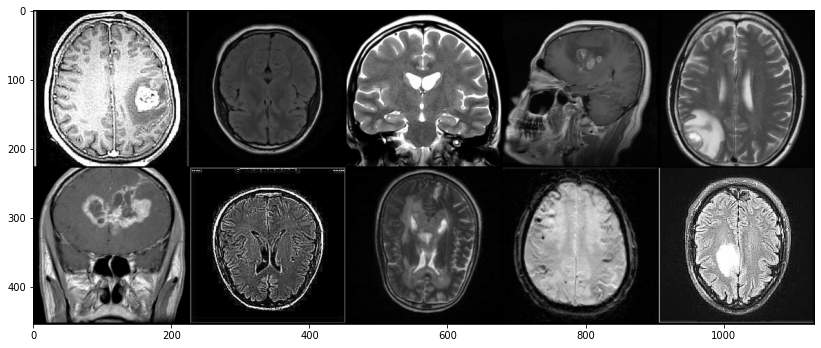

In [130]:
for image, label in train_loader:
    break

print('Label:', label.numpy())
print('Class:', *np.array([class_name[i] for i in label]))

# the default nrow is 8
im = make_grid(image, nrow=5)  

# Print the images
plt.figure(figsize=(14,6))
plt.imshow(np.transpose(im, (1, 2, 0)))

In [131]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=2)
        self.batchnorm1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(20)
        self.fc2 = nn.Linear(20*13*13, 2)
        self.dropout = nn.Dropout(0.5)
        
        # placeholder for the gradients
        self.gradients = None
        # disect the network to access its last convolutional layer
        self.features_conv = nn.Sequential(*list(self.children()))[:-2]

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.batchnorm1(X)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.batchnorm2(X)

        # register the hook
        h = X.register_hook(self.activations_hook)
        
        X = X.view(-1, 20*13*13)
        X = self.fc2(X)
    
        return F.log_softmax(X , dim =1)

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [132]:
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
count_parameters(model)
i = 0

   270
    10
    10
    10
  1800
    20
    20
    20
  6760
     2
______
  8922


In [146]:
epoch = 1
losses = []
train_losses = []
train_correct = []
test_losses = []
test_correct = []

for i in range(epoch):
    trn_corr = 0
    tst_corr = 0

    for b,(x_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(x_train)
        loss = criterion(y_pred,y_train)
     
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%64 == 0 or b%322 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{batch_size*b:6}/3220]  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(batch_size*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

epoch:  0  batch:   64 [   640/3220]  loss: 0.20428964 accuracy:  98.906%
epoch:  0  batch:  128 [  1280/3220]  loss: 0.00514418 accuracy:  99.219%
epoch:  0  batch:  192 [  1920/3220]  loss: 0.02378533 accuracy:  99.219%
epoch:  0  batch:  256 [  2560/3220]  loss: 0.02370150 accuracy:  99.102%
epoch:  0  batch:  320 [  3200/3220]  loss: 0.02859105 accuracy:  98.969%
epoch:  0  batch:  322 [  3220/3220]  loss: 0.00410192 accuracy:  98.975%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: [0 1 1 0 0 0 1 1 1 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


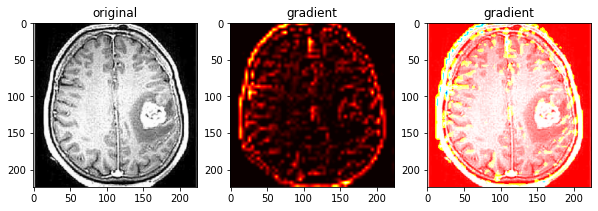

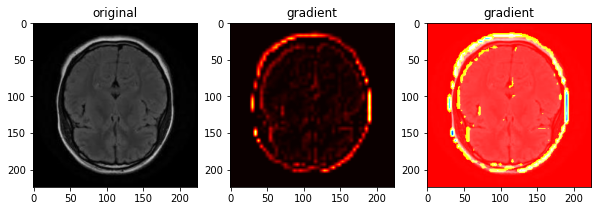

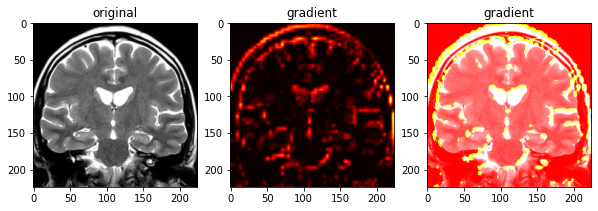

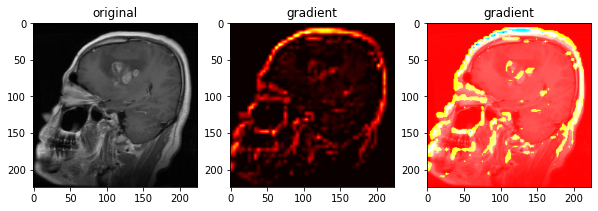

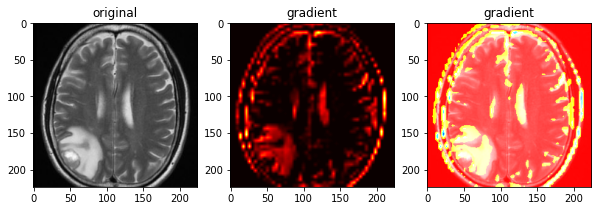

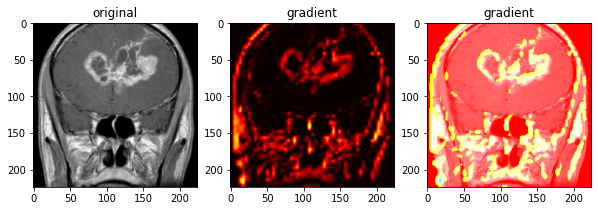

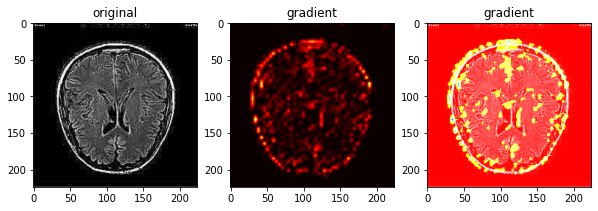

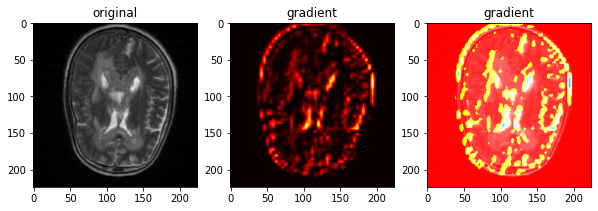

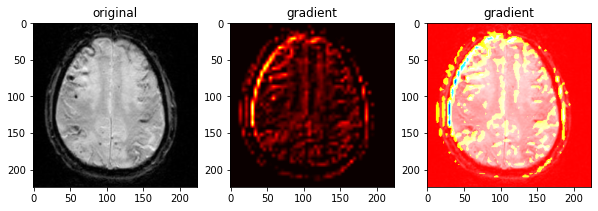

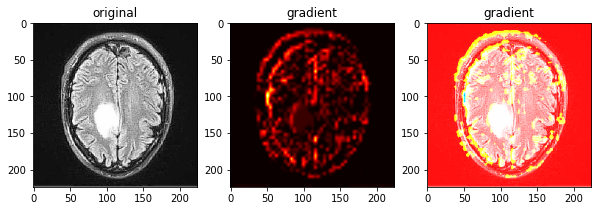

In [150]:
print('Label:', label.numpy())
for i in range(len(image)):
    # get the most likely prediction of the model
    np_img_grad_cam = np.array(image[i])
    np_img_grad_cam = np_img_grad_cam.reshape((1,3, 224, 224))
    imag = torch.tensor(np_img_grad_cam, requires_grad=True)
    scores = model(imag)
    score_max_ind = scores.argmax(dim = 1)
    # pull the gradients out of the model
    gradients = model.get_activations_gradient()
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    # get the activations of the last convolutional layer
    activations = model.get_activations(imag).detach()
    # weight the channels by corresponding gradients
    for i in range(i):
        activations[:, i, :, :] *= pooled_gradients[i]
        # average the channels of the activations

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.minimum(heatmap, 0)

    # # normalize the heatmap
    heatmap /= torch.min(heatmap)

    # Resize the activation map of size 7x7 to the original image size (224x224)
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (224, 224))[0]
    
    fig = plt.figure(figsize=(10, 8))

    fig.add_subplot(1, 3, 1)
    plt.imshow((np_img_grad_cam.transpose(0,2,3,1).reshape(224,224,3)*255).astype(np.uint8))
    plt.title("original")

    # draw the heatmap
    fig.add_subplot(1, 3, 2)
    plt.imshow(heatmap.squeeze(), cmap=plt.cm.hot)
    plt.title("gradient")

    fig.add_subplot(1, 3, 3)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + np_img_grad_cam.transpose(0,2,3,1).reshape(224,224,3)
    plt.imshow(superimposed_img)
    plt.title("gradient")

# plt.show()